# 02 Parameter estimation under Artemisinin treatment

Now that we have estimated the parameters in the control case, we are going to study how they vary under artemisinin treatment. There are six parameters that we estimate, and that might vary under drug treatment:
 - $\rho_S$ (which also contains $\delta_{SC}$);
 - $\sigma_1$;
 - $\rho_C$;
 - $\delta_{CB}$;
 - $\mu_B$;
 - $\sigma_2$.
 
But the two error parameters might not be very interesting in that context, as they don't impact the dynamics of the process, but rather account for its ability to fit the data.

What we want to know is **What parameters of the model must vary, in order to account for the change of dynamics that we observe *in vitro*?**

# Method
We are going to adjust some of the parameters to the data under treatment, while keeping the others at the same value as in the untreated case. We will do this for every combination of parameters that keep 0 parameter constant, then with 1 constant parameter, then with 2... Which means that we'll optimize $2^p$ models, where $p$ is the number of parameters. With 6 distinct parameters to estimate, this creates 64 parameters combinations to estimate.

With these $2^p$ optimized parameters sets we can compute an AIC for every form of the model and determine what parameter combinations we should keep.

# Initiation

In [39]:
import numpy as np
from itertools import combinations

import SCB_estimate as SCBe
import Custom_Estimation_Routines as CER
import Error_Model as EM
import Selection_Criteria as SC
import Profile_Likelihood as PL
import Generalized_Profile_Likelihood as GPL

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
%matplotlib inline

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

experiment='Experiments_1-3'
Experiments=(1, 2, 3)

duration=5

Disp_params=(0,2,3,4)  #parameters to display in figures.
xticks = (r'$\rho_S$', r'$b_1$', r'$\rho_C$', r'$\delta_{CB}$', r'$\rho_B$',r'$b_2$')

t=np.arange(duration)

if len(Experiments)==1:
    experiment=Experiments[0]
    DMSO_data=np.genfromtxt('../data/Cell_counts_%i_DMSO_PT.csv'%(experiment))[:,:duration]
    Arte_data=np.genfromtxt('../data/Cell_counts_%i_Arte.csv'%(experiment))[:,:duration]
else:
    N=len(Experiments)
    DMSO_data=np.empty((N,3,duration))
    Arte_data=np.empty((N,3,duration))
    
    for i in range(N):
        dmso=np.genfromtxt('../data/Cell_counts_%i_DMSO_PT.csv'%(Experiments[i]))
        arte=np.genfromtxt('../data/Cell_counts_%i_Arte.csv'%(Experiments[i]))
        if Experiments[i] in ('AG111','AG112','AG114'):
            dmso=dmso.reshape((3,3,5))
            dmso=np.mean(dmso, axis=1)
            arte=arte.reshape((3,3,5))
            arte=np.mean(arte, axis=1)
        DMSO_data[i]=dmso[:duration]
        Arte_data[i]=arte[:duration]
rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2 = np.genfromtxt('../data/01_DMSO_parameter_estimation/%s_%id_DMSO_PT.params'%(experiment, duration-1, ))
Params_DMSO = np.array([rhoS,b1,rhoC,deltaCB,rhoB,b2])
Params1_DMSO=np.array([rhoS, b1])
Params2_DMSO=Params_DMSO[2:]
print('\t', Params_DMSO)

Parameter_labels=[r'$\rho_S$',r'$\delta_{SC}$',r'$b_1$',r'$\rho_C$',r'$\delta_{CB}$',r'$\rho_B$',r'$b_2$']
Bounds=[(None,None),(0,None),(None,None),(0,None),(None,None),(0,None)]

color = '#ee1289ff'

	 [0.86390434 0.11756698 1.24993302 0.62866307 0.46135846 0.24257426]


the following cell defines a function to compute the optimal values of parameters with any combination of fixed and free parameters.

# Model without parameter change

That's the easiest case, as we have no optimization here

In [40]:
L1_DMSO=EM.logLikelihood_ProportionalError(Params1_DMSO,DMSO_data[:,0],SCBe.S,t,DMSO_data[0,0,0],log=False)
L2_DMSO=EM.logLikelihood_ProportionalError(Params2_DMSO,DMSO_data[:,1:],SCBe.TB,t,[DMSO_data[0,1,0],0,0],np.array([rhoS, deltaSC]), False)   

print('\t', L1_DMSO,L2_DMSO,L1_DMSO+L2_DMSO)

	 306.41078035655687 593.1771944061586 899.5879747627155


In [41]:
L1_Arte_0=EM.logLikelihood_ProportionalError(Params1_DMSO,Arte_data[:,0],SCBe.S,t,Arte_data[0,0,0],log=False)
L2_Arte_0=EM.logLikelihood_ProportionalError(Params2_DMSO,Arte_data[:,1:],SCBe.TB,t,[Arte_data[0,1,0],0,0],np.array([rhoS, deltaSC]),False)

print('\t', L1_Arte_0+L2_Arte_0)

	 1023.362655750167


# Model with parameter change

In [42]:
i=0
a=np.arange(6)
k=0

Data=[]
save=True

for i in np.arange(7):
    data=np.empty(np.concatenate((6*np.ones(i,dtype='int'), np.array([7]) )))
    for j in combinations(a,i):
        print('Varying parameters: ',list(j))
        opt=GPL.GPL_estimation(np.array(j),Arte_data,t,Params_DMSO,[L1_Arte_0,L2_Arte_0],Bounds,verbose_success=False)
        k+=1
        data[j][:-1] = opt['parameters']
        data[j][-1]  = opt['error']
    if save:
        path='../data/02_Artemisinin_parameter_estimation/%s_%id_%i_change.npy'%(experiment,duration-1,i)
        np.save(path,data)
    for j in combinations(a,i):
        print('Parameters changing:',j,'\tLikelihood: %.4g'%data[j][-1])
    Data+=[data]

Varying parameters:  []
Parameters changing: () 	Likelihood: 1023
Varying parameters:  [0]
Varying parameters:  [1]
Varying parameters:  [2]
Varying parameters:  [3]
Varying parameters:  [4]
Varying parameters:  [5]
Parameters changing: (0,) 	Likelihood: 974.3
Parameters changing: (1,) 	Likelihood: 982.9
Parameters changing: (2,) 	Likelihood: 989.7
Parameters changing: (3,) 	Likelihood: 1006
Parameters changing: (4,) 	Likelihood: 957.4
Parameters changing: (5,) 	Likelihood: 996.3
Varying parameters:  [0, 1]
Varying parameters:  [0, 2]
Varying parameters:  [0, 3]
Varying parameters:  [0, 4]
Varying parameters:  [0, 5]
Varying parameters:  [1, 2]
Varying parameters:  [1, 3]
Varying parameters:  [1, 4]
Varying parameters:  [1, 5]
Varying parameters:  [2, 3]
Varying parameters:  [2, 4]
Varying parameters:  [2, 5]
Varying parameters:  [3, 4]
Varying parameters:  [3, 5]
Varying parameters:  [4, 5]
Parameters changing: (0, 1) 	Likelihood: 965.5
Parameters changing: (0, 2) 	Likelihood: 939.7
P

In [28]:
load=True
if load:
    Data=[]
    for i in np.arange(7):
        path='../data/02_Artemisinin_parameter_estimation/%s_%id_%i_change.npy'%(experiment,duration-1,i)
        data=np.load(path)
        print(data.shape)
        Data+=[data]
        

(7,)
(6, 7)
(6, 6, 7)
(6, 6, 6, 7)
(6, 6, 6, 6, 7)
(6, 6, 6, 6, 6, 7)
(6, 6, 6, 6, 6, 6, 7)


# Model selection

First we're going to select the best models of artemisinin treatments using the corrected AIC and the corresponding Akaike's weights.

Model (0, 1, 2, 3)
-2ln(L): 867.4	AIC:    875.4	AICc:   879.4	Delta:  0	W:      0.4501
Model (0, 1, 2, 3, 5)
-2ln(L): 863.1	AIC:    873.1	AICc:   879.7	Delta:  0.3622	W:      0.3756
Model (0, 1, 2, 3, 4)
-2ln(L): 867.1	AIC:    877.1	AICc:   883.7	Delta:  4.353	W:      0.05106
Model (0, 2, 3, 5)
-2ln(L): 871.8	AIC:    879.8	AICc:   883.8	Delta:  4.473	W:      0.04808
Model (0, 2, 3)
-2ln(L): 876.2	AIC:    882.2	AICc:   884.3	Delta:  4.967	W:      0.03755

Number of good models according to w_AICc: 5



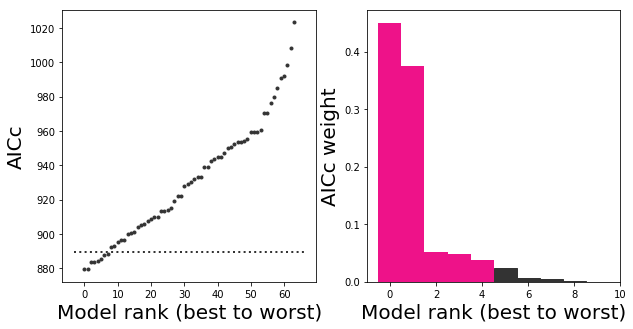

In [32]:
#Unsorted lists definitions (i.e. models are ordered as they were estimated, not according to a ranking based on a selection criterion)
Models=[()]
Likelihoods=[Data[0][-1]]
AICs=[SC.AIC(Data[0][-1],0)]
AICcs=[SC.AICc(Data[0][-1],(3*duration),0)]

for i in range(1,7):
    for j in combinations(np.arange(6),i):
        Models+=[j]
        Likelihoods+=[Data[i][j][-1]]
        AICs+=[SC.AIC(Data[i][j][-1],len(j))]
        AICcs+=[SC.AICc(Data[i][j][-1],3*duration,len(j))]

Delta = np.array(AICcs)-np.min(AICcs)  #AICc difference between each model and the best one
Weights=np.exp(-0.5*Delta)/np.sum(np.exp(-0.5*Delta))  #AICcs weight of each model

Parameters=np.empty((6,len(Models)))
Relative_params=np.empty((64,len(Disp_params)))

for i in range(len(Models)):
    model=Models[i]
    Parameters[:,i]=Data[len(model)][model][:-1]

Disp_xticks=[]
for i in range(len(Disp_params)):
    Relative_params[:,i] = Parameters[Disp_params[i]]/Params_DMSO[Disp_params[i]]
    Disp_xticks+=[xticks[Disp_params[i]]]

arg=np.argsort(AICcs) #list of models indexes sorted by increasing AICc
Best_models_AICc=[]  #list of best models according to the AICc criterion
Best_models_w = [] #list of best models according to the Akaike's weight
Weights_sorted=np.sort(Weights)[::-1] #list of models Akaike's weights sorted decreasingly

plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

#Building the ranking by AICc
for i in arg:
    if AICcs[i]<=AICcs[arg[0]]+10:  #we use the D_AICc < 10 criterion for a "good fit".
        Best_models_AICc+=[i]

#Building the ranking by Aikaike's weights
imax=0
while np.sum(Weights_sorted[:imax]) <=0.95:
    Best_models_w+=[arg[imax]]
    print('Model',Models[arg[imax]])   #we remind which parameters vary in that model
    print('-2ln(L): %.4g\tAIC:    %.4g\tAICc:   %.4g\tDelta:  %.4g\tW:      %.4g'%(Likelihoods[arg[imax]],AICs[arg[imax]],AICcs[arg[imax]],Delta[arg[imax]],Weights[arg[imax]]))
    imax+=1
    
print("\nNumber of good models according to w_AICc: %i\n"%imax)

for i in range(len(arg)):
    ax[0].plot(i,AICcs[arg[i]],'.',c='0.2')
ax[0].plot(ax[0].get_xlim(),[10+np.min(AICcs),10+np.min(AICcs)],':',linewidth=2,c='0.2',label='min(AICc)+10')
ax[0].set_xlabel('Model rank (best to worst)',fontsize=20)
ax[0].set_ylabel('AICc',fontsize=20)
#plt.legend(loc='upper left',fontsize=20)

ax[1].bar(np.arange(imax),np.sort(Weights)[::-1][:imax],1,facecolor=color,edgecolor=None)
ax[1].bar(np.arange(imax,2*imax),np.sort(Weights)[::-1][imax:2*imax],1,facecolor='0.2',edgecolor='0.2')
ax[1].set_xlabel('Model rank (best to worst)',fontsize=20)
ax[1].set_ylabel('AICc weight',fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/02_Artemisinin_parameter_estimation/%s_%id_Artemisinin_Selection.pdf'%(experiment, duration-1),dpi='figure',bbox_inches='tight')

# Parameter variations

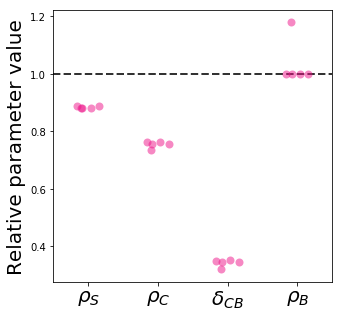

In [34]:
plt.rcParams['figure.figsize']=(5,5)

plt.xlim(-0.5,3.5)
plt.plot(plt.xlim(), (1,1), '--', c='0.2', linewidth=2)

x = np.random.normal(0, 0.12, imax)
for i in range(len(Disp_params)):
    for j in range(imax):
        plt.plot(x[j]+i, Relative_params[arg[j],i], 'o', markersize=8, c=color, alpha=0.5, markeredgecolor='None')

plt.xticks(np.arange(len(Disp_xticks)),Disp_xticks,fontsize=20)
plt.ylabel('Relative parameter value', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/02_Artemisinin_parameter_estimation/%s_%id_Artemisinin_BestModelsRelativeParametersJitter.pdf'%(experiment, duration-1), dpi='figure', bbox_inches='tight')

# Simulation
We use the best model of treatment for simulation

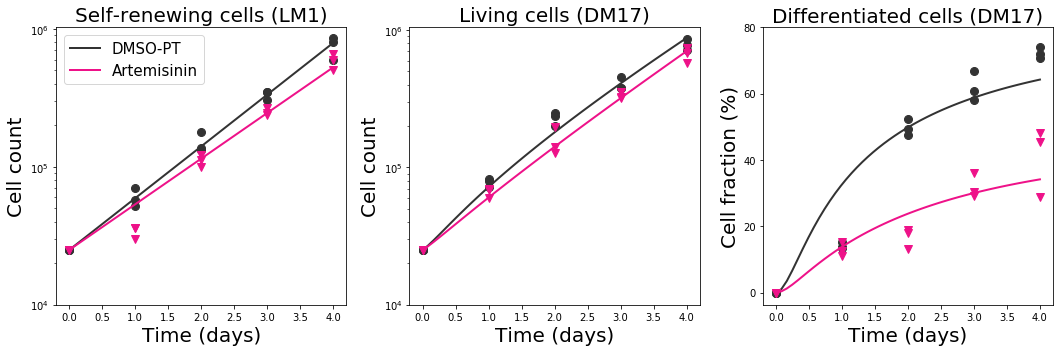

In [31]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0, duration-1)

Exp=np.array([DMSO_data, Arte_data])
Exp[:,:,2]/=Exp[:,:,1]

Params_Arte=Parameters[:,arg[0]]
Params = np.array((Params_DMSO, Params_Arte))

colors=('0.2',color)
markers = ('o', 'v')
Labels=('Self-renewing cells (LM1)', 'Living cells (DM17)', 'Differentiated cells (DM17)')
Ylabels=('Cell count', 'Cell count', 'Cell fraction (%)')
Treatments=('DMSO-PT','Artemisinin')

for i in range(2): #treatment
    rhoS, b1, rhoC, deltaCB, rhoB, b2 = Params[i]
    deltaSC = rhoS + 0.5*np.log(25000)
    S_simul = SCBe.S(T, 25000, rhoS)
    TB_simul = SCBe.TB(T, [25000,0,0], rhoS, deltaSC, rhoC, deltaCB, rhoB)
    Simul = np.vstack((S_simul, TB_simul[0], TB_simul[1]/TB_simul[0]))
    
    for j in range(3):
        for k in range(len(Experiments)):
            ax[j].plot(t, Exp[i,k,j],markers[i],markersize=8,c=colors[i], markeredgecolor=colors[i])
        ax[j].plot(T, Simul[j], linewidth=2, c=colors[i], label=Treatments[i])
        if j <=1:
            ax[j].set_yscale('log')
        ax[j].set_title(Labels[j], fontsize=20)
        ax[j].set_xlabel('Time (days)', fontsize=20)
        ax[j].set_ylabel(Ylabels[j], fontsize=20)
        ax[j].set_xlim((-0.2, duration-0.8))
for j in range(2):
    ax[j].set_yticks((1e4, 1e5, 1e6)) 
ax[2].set_yticks(0.2*np.arange(5))
ax[2].set_yticklabels(['0','20','40','60','80'])
ax[0].legend(loc='upper left',fontsize=15)
plt.tight_layout()

savefig=True
if savefig:
    plt.savefig('../figures/02_Artemisinin_parameter_estimation/%s_%id_Artemisinin_BestModel_Simulation.pdf'%(experiment, duration-1), dpi='figure', bbox_inches='tight')